Batch 0:
IOU: 0.0010
Precision: 1.0000
Recall: 0.0010
F1 Score: 0.0019
Pixel Accuracy: 0.0010
Latency: 4.2537 ms
Inference Time: 0.0043 s
--------------------------------------------------
Batch 1:
IOU: 0.0174
Precision: 1.0000
Recall: 0.0174
F1 Score: 0.0342
Pixel Accuracy: 0.0174
Latency: 4.8906 ms
Inference Time: 0.0049 s
--------------------------------------------------
Batch 2:
IOU: 0.0010
Precision: 1.0000
Recall: 0.0010
F1 Score: 0.0020
Pixel Accuracy: 0.0010
Latency: 4.1748 ms
Inference Time: 0.0042 s
--------------------------------------------------
Batch 3:
IOU: 0.0040
Precision: 1.0000
Recall: 0.0040
F1 Score: 0.0080
Pixel Accuracy: 0.0040
Latency: 4.2332 ms
Inference Time: 0.0042 s
--------------------------------------------------
Batch 4:
IOU: 0.0009
Precision: 1.0000
Recall: 0.0009
F1 Score: 0.0017
Pixel Accuracy: 0.0009
Latency: 4.2796 ms
Inference Time: 0.0043 s
--------------------------------------------------
Batch 5:
IOU: 0.0000
Precision: 1.0000
Recall: 0.0000
F

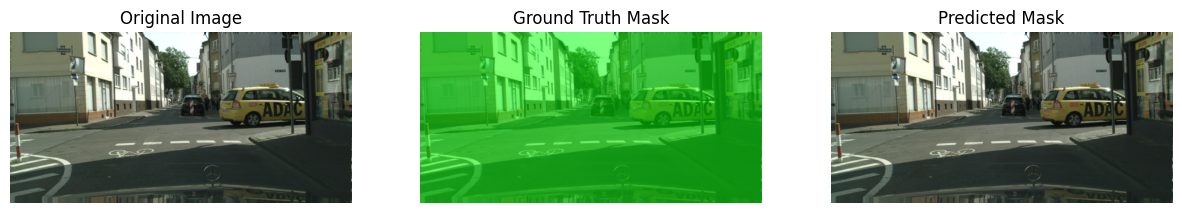

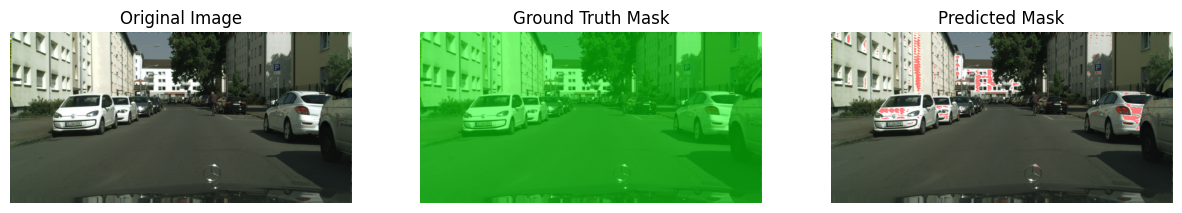

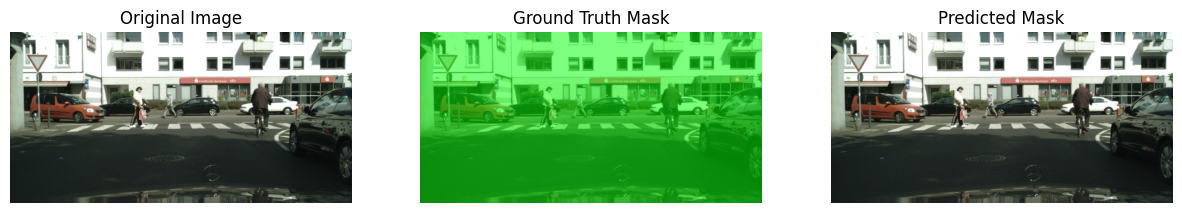

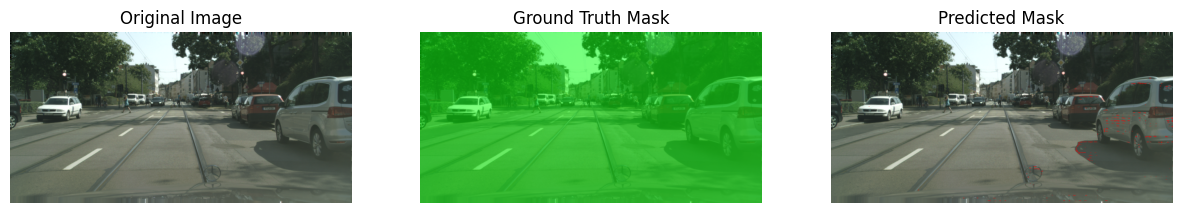

In [8]:
import numpy as np
import torch
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

# Dataset class for Cityscapes (validation dataset with labels)
class CityscapesDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        # Collect all image and mask file paths
        self.image_files = []
        self.mask_files = []
        for city in os.listdir(image_dir):
            city_image_path = os.path.join(image_dir, city)
            city_label_path = os.path.join(label_dir, city)
            if os.path.isdir(city_image_path) and os.path.isdir(city_label_path):
                for file_name in os.listdir(city_image_path):
                    if file_name.endswith('_leftImg8bit.png'):
                        img_path = os.path.join(city_image_path, file_name)
                        mask_file_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                        mask_path = os.path.join(city_label_path, mask_file_name)
                        if os.path.exists(mask_path):
                            self.image_files.append(img_path)
                            self.mask_files.append(mask_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]
        
        image = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize image and mask to 1024 size
        r = min(1024 / image.shape[1], 1024 / image.shape[0])
        new_size = (int(image.shape[1] * r), int(image.shape[0] * r))
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)

        return image, mask

# Define paths to Cityscapes validation dataset images and labels
val_image_dir = "segment-anything-2/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val"  # Replace with actual validation image path
val_label_dir = "segment-anything-2/cityscapes/gtFine_trainvaltest/gtFine/val"       # Replace with actual validation label path

# Create dataset and dataloader for validation
val_dataset = CityscapesDataset(val_image_dir, val_label_dir)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Load SAM2 model and fine-tuned checkpoint
sam2_checkpoint = 'sam2_cityscapes_final.pth'  # Fine-tuned model checkpoint
model_cfg = 'sam2_hiera_s.yaml'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build and load model
sam2_model = build_sam2(model_cfg, None, device=device)
sam2_model.load_state_dict(torch.load(sam2_checkpoint, map_location=device))
sam2_model.to(device)
sam2_model.eval()  # Set model to evaluation mode

# Initialize SAM2ImagePredictor
predictor = SAM2ImagePredictor(sam2_model)

# Initialize metrics accumulators
ious, precisions, recalls, f1s, latencies, pixel_accuracies = [], [], [], [], [], []

# For storing images and masks to display later
images_to_display = []
pred_masks_to_display = []
true_masks_to_display = []

def apply_color_overlay(image, mask, color, alpha=0.5):
    """Apply a color overlay to the mask and blend it with the original image."""
    mask = mask.astype(bool)  # Convert mask to boolean
    overlay = image.copy()  # Copy original image
    overlay[mask] = image[mask] * (1 - alpha) + np.array(color) * alpha
    return overlay

# Evaluation loop for validation images and masks
for batch_idx, (image, true_mask) in enumerate(val_dataloader):
    try:
        image_np = image.squeeze(0).numpy()  # Squeeze batch dimension

        # Make sure image is properly formatted (C, H, W)
        image_np = np.transpose(image_np, (2, 0, 1))  # Convert from (H, W, C) to (C, H, W)

        # Convert image_np to a torch tensor and normalize
        image_tensor = torch.from_numpy(image_np).float() / 255.0  # Convert to float and scale pixel values
        if image_tensor.shape[0] != 3:
            raise ValueError(f"Expected 3 channels but got {image_tensor.shape[0]} channels")

        # Normalize using mean and std of the dataset (assume RGB normalization stats)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_tensor = (image_tensor - mean) / std  # Normalize image

        # Convert the normalized tensor back to a NumPy array (HWC format)
        image_np_normalized = image_tensor.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

        # Set the normalized image for the predictor (expecting NumPy array in HWC format)
        predictor.set_image(image_np_normalized)

        # Retrieve high-res features from the image embedding
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

        # Inference: Generate segmentation mask using the predictor
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=None,
                                                                                 boxes=None,
                                                                                 masks=None)

        repeat_image = False

        low_res_masks_start_time = torch.cuda.Event(enable_timing=True)
        low_res_masks_end_time = torch.cuda.Event(enable_timing=True)

        low_res_masks_start_time.record()

        low_res_masks, _, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            repeat_image=repeat_image,
            high_res_features=high_res_features  
        )

        low_res_masks_end_time.record()

        torch.cuda.synchronize()

        latency_ms = low_res_masks_start_time.elapsed_time(low_res_masks_end_time)

        pred_mask = predictor._transforms.postprocess_masks(low_res_masks.detach(), predictor._orig_hw[-1])[0]
        
        pred_mask_binary = (torch.sigmoid(pred_mask).cpu().numpy() > 0.5).astype(np.uint8)

    except Exception as e:
        print(f"Error processing batch {batch_idx}: {e}")
        continue

    true_mask_binary = (true_mask.numpy() > 0).astype(np.uint8)

    try:
        # Compute metrics with 'binary' average and handle zero division
        iou_score = jaccard_score(
            true_mask_binary.flatten(),
            pred_mask_binary.flatten(),
            average='binary',
            zero_division=1
        )
        precision_score_val = precision_score(
            true_mask_binary.flatten(),
            pred_mask_binary.flatten(),
            average='binary',
            zero_division=1
        )
        recall_score_val = recall_score(
            true_mask_binary.flatten(),
            pred_mask_binary.flatten(),
            average='binary',
            zero_division=1
        )
        f1_score_val = f1_score(
            true_mask_binary.flatten(),
            pred_mask_binary.flatten(),
            average='binary',
            zero_division=1
        )

        # Compute pixel accuracy
        pixel_accuracy_val = np.mean(true_mask_binary.flatten() == pred_mask_binary.flatten())

        ious.append(iou_score)
        precisions.append(precision_score_val)
        recalls.append(recall_score_val)
        f1s.append(f1_score_val)
        latencies.append(latency_ms)
        pixel_accuracies.append(pixel_accuracy_val)

        # Collect images and masks for display
        if len(images_to_display) < 4:
            # Convert image back to original scale for display
            image_to_show = (image_np_normalized * std.numpy().reshape(1,1,3) + mean.numpy().reshape(1,1,3))
            image_to_show = np.clip(image_to_show * 255.0, 0, 255).astype(np.uint8)
            images_to_display.append(image_to_show)
            pred_masks_to_display.append(pred_mask_binary.squeeze(0))  # Squeeze the extra dimension here
            true_masks_to_display.append(true_mask_binary.squeeze(0))

        # Print metrics for this batch
        print(f"Batch {batch_idx}:")
        print(f"IOU: {iou_score:.4f}")
        print(f"Precision: {precision_score_val:.4f}")
        print(f"Recall: {recall_score_val:.4f}")
        print(f"F1 Score: {f1_score_val:.4f}")
        print(f"Pixel Accuracy: {pixel_accuracy_val:.4f}")
        print(f"Latency: {latency_ms:.4f} ms")
        print(f"Inference Time: {latency_ms/1000:.4f} s")
        print("-" * 50)

    except Exception as e:
        print(f"Error calculating metrics for batch {batch_idx}: {e}")
        continue

# Calculate mean metrics while handling potential None or NaN values
mean_iou = np.nanmean(ious) if ious else float('nan')
mean_precision = np.nanmean(precisions) if precisions else float('nan')
mean_recall = np.nanmean(recalls) if recalls else float('nan')
mean_f1 = np.nanmean(f1s) if f1s else float('nan')
mean_latency_ms = np.nanmean(latencies) if latencies else float('nan')
mean_pixel_accuracy = np.nanmean(pixel_accuracies) if pixel_accuracies else float('nan')

print("Summary Metrics:")
print(f"Mean IOU: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")
print(f"Mean Latency: {mean_latency_ms:.4f} ms")

# Define colors for ground truth and predicted masks
true_mask_color = [0, 255, 0]  # Green for ground truth
pred_mask_color = [255, 0, 0]  # Red for predicted mask

# Display images with colored masks
num_images_to_display = min(4, len(images_to_display))
for i in range(num_images_to_display):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images_to_display[i])
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    true_overlay = apply_color_overlay(images_to_display[i], true_masks_to_display[i], true_mask_color)
    axes[1].imshow(true_overlay)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    pred_overlay = apply_color_overlay(images_to_display[i], pred_masks_to_display[i], pred_mask_color)
    axes[2].imshow(pred_overlay)
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()
